# CLV Estimation
---

**본 분석은 더미 데이터를 사용하였습니다. 따라서, 실제와 다른 결과를 나타내고 있습니다.**

#### 목차
---

1. 요약
2. 사용 데이터
3. 분석 설계<br>
3-1) 가정<br>
3-2) 공식
4. 분석 과정<br>
4-1) 문제 제기: 예측 모델 선택<br>
4-2) 문제 제기: 코호트 반영<br>
4-3) 분석
5. 결과
6. 한계점

## 1. 요약
---

본 분석은 유저 1명의 가치를 판단하기 위해 실행되었습니다. 유저 1명이 평생동안 사용할 금액의 기댓값(E(CLV))을 구하는 과정을 보이고 있습니다.<br>
분석을 위해 실제로 구독을 진행하고 있는 모든 유저의 데이터를 사용하였습니다.<br>
본 분석을 토대로 나온 E(CLV)값을 활용하여 마케팅시 CAC를 구하거나 유저 증감에 따른 금액 산정 등을 진행하였습니다.(실제로는 6개월간의 기대 수익을 주로 사용)<br>
E(CLV)를 구하기 위해서 생존율을 sBG 모델을 사용하여 학습시켰으며, M+200을 무한대로 대체 사용하여 E(CLV)를 구하였습니다.<br>
최근 트렌드를 반영하기 위해 최근의 코호트 집단만 활용하게 된다면 예측값의 정확도가 떨어질 가능성이 크고, 예측의 정확도를 위해 과거의 코호트 집단을 활용하게 된다면 최근 트렌드를 반영하기 어렵기 때문에 1년간의 코호트 집단(1개월 주기)을 모두 학습시킨 뒤 그 평균을 사용하였습니다.<br>
본 분석은 평생 가치를 측정하는 것이기 때문에 변화하는 스타트업 상황에서 그대로 사용하기 어렵다는 점, 다양한 유저의 특성을 고려하지 않은 점, 편의를 위해 단순화하여 모델링한 점, 데이터 오류의 가능성 등에 의해 실제 적용에 유의하여야합니다.

## 2. 사용 데이터
---

In [787]:
import warnings

# 모든 경고 무시
warnings.filterwarnings("ignore")

import pandas_gbq
from google.oauth2 import service_account

# 더미데이터 불러오기
# 실제 sql코드는 동일 파일 내의 raw_sql을 참고해주세요
query = """
SELECT *
FROM `pickleplus-data.db_data.retention`
"""

# 인증 키 경로
credentials = service_account.Credentials.from_service_account_file('../../secret_key_portfolio/pickleplus-data-f87588a0b531.json')

# 프로젝트 ID
project_id = 'pickleplus-data'

# 빅쿼리 데이터를 데이터프레임으로 불러오기
df = pandas_gbq.read_gbq(query, project_id=project_id, credentials=credentials)

df

,n_value,retention,first_month
0,1,0.780171,2023-04-01
1,2,0.608312,2023-04-01
2,3,0.480358,2023-04-01
3,4,0.375362,2023-04-01
4,5,0.292097,2023-04-01
...,...,...,...
67,5,0.225788,2023-11-01
68,1,0.749511,2023-12-01
69,2,0.561961,2023-12-01
70,3,0.416188,2023-12-01


## 3. 분석 설계
---

### 3-1) 가정
---

- 고객 획득비용은 고려하지 않습니다.
- 카드 수수료, 인건비 등 비용은 고려하지 않습니다.
- 시간 흐름에 따른 화폐가치 하락을 고려하지 않습니다.
- 생존 여부는 한 달 기준으로 하며, 중간 이탈시 환불 금액은 고려하지 않습니다.
- 정산 보장제에 따른 손해액은 계산하지 않습니다.

### 3-2) 공식
---

- $E(CLV) = \sum_{t=1}^\infty m \frac {S(t)} {(1+d)^t}$
- $m$: 구독 수수료(파티장: 490원, 파티원: 990원)
- $S(t)$: $t$시점에서의 생존 함수. 단, $t=0$이면 $S(t)=1$ 
- $d$: 화폐 가치 하락 비율, 이 분석에서는 0으로 간주한다.

- $e.g.$

In [788]:
df[df['first_month'] == '2023-04-01']

,n_value,retention,first_month
0,1,0.780171,2023-04-01
1,2,0.608312,2023-04-01
2,3,0.480358,2023-04-01
3,4,0.375362,2023-04-01
4,5,0.292097,2023-04-01
5,6,0.227401,2023-04-01
6,7,0.185749,2023-04-01
7,8,0.140905,2023-04-01
8,9,0.119285,2023-04-01
9,10,0.094718,2023-04-01


- $E(CLV) = 865 + (865 \times 0.78) + (865 \times 0.60) + (865 \times 0.48) + ... + (865 \times S(t))$

- 생존함수 $S(t)$에 대하여
    - $S(t| \theta) = (1- \theta)^t$
- 리텐션 $r(t)$에 대하여
    - $r(t) = \frac {S(t)} {S(t-1)}$
- $\theta \sim beta(\alpha, \beta)$이고, $beta$ $geometric$ 분포에 따라
    - $p(T=t | \alpha, \beta) = \frac {\beta + t - 2} {\alpha + \beta + t - 1} p(T = t-1)$ $for$ $t>1$
    - $r(t) = \frac {\beta + t - 2} {\alpha + \beta + t - 1}$ 

**reference**
- https://www.brucehardie.com/papers/021/sbg_2006-05-30.pdf

## 4. 분석 과정
---

### 4-1) 문제 제기: 예측 모델 선택
---

**Problem**<br>
- 일반적인 함수 적합시 적합에는 문제가 없으나, 예측에서 실제와 다른 문제가 발생합니다.

**Solution**<br>
- sBG 모델 사용

**Example**<br>

- 일반 함수 적합시
1. 지수함수(func 1):    $a e^{-bx} + c$
2. n차식(func 2):     $ax^b+c$

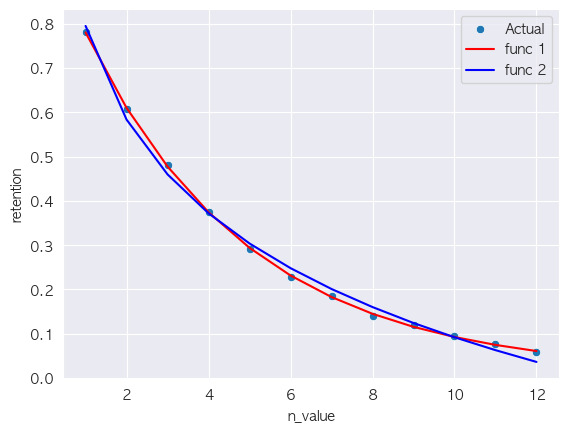

func 1 mean absolute error: 	 0.00
func 2 mean absolute error: 	 0.01


In [789]:
# curve_fit 사용하여 적합
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def func1(X, a, b, c):
    return a * np.exp(-b * X) + c

def func2(X, a, b, c):
    return a * X ** b + c

# 예시용 데이터프레임
df_eg = df.copy()

# 2023-1 코호트 사용
y = df_eg[(df_eg['first_month'] == '2023-04-01')]['retention']
X = df_eg[(df_eg['first_month'] == '2023-04-01')]['n_value']

# 함수 적합
popt1, pcov = curve_fit(func1, X, y, maxfev=5000)
popt2, pcov = curve_fit(func2, X, y, maxfev=5000)

# 예측값
y_pred1 = func1(X, *popt1)
y_pred2 = func2(X, *popt2)

# 시각화
sns.scatterplot(x=X, y=y, label='Actual')
sns.lineplot(x=X, y=y_pred1, color='r', label='func 1')
sns.lineplot(x=X, y=y_pred2, color='b', label='func 2')
plt.legend(loc='best')
plt.show()

# 에러 확인
from sklearn.metrics import mean_absolute_error

print(f'func 1 mean absolute error: \t {mean_absolute_error(y, y_pred1):.2f}')
print(f'func 2 mean absolute error: \t {mean_absolute_error(y, y_pred2):.2f}')

- 현재를 반영하는 데에 큰 문제가 보이지 않습니다.

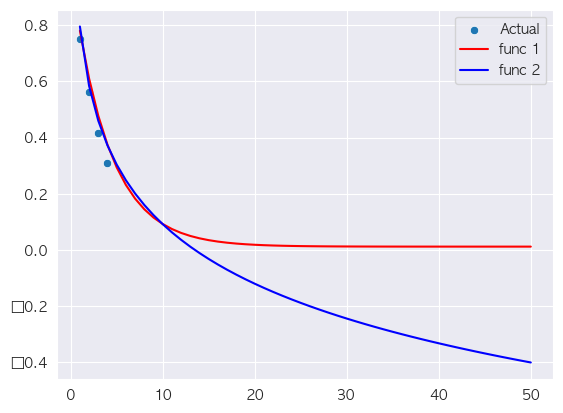

In [804]:
# M+100 예측
y_pred1 = func1(np.linspace(1,50), *popt1)
y_pred2 = func2(np.linspace(1,50), *popt2)

# 시각화
sns.scatterplot(x=X, y=y, label='Actual')
sns.lineplot(x=np.linspace(1,50), y=y_pred1, color='r', label='func 1')
sns.lineplot(x=np.linspace(1,50), y=y_pred2, color='b', label='func 2')
plt.legend(loc='best')
plt.show()

- func 1: 점근선이 0 이상에서 형성되어 CLV가 과대 집계 됩니다.
- func 2: 음수가 나와 실제와 맞지 않습니다.


**위와 같은 이유로 예측에서 사용할 수 없습니다.**

- sBG 모델과 일반 함수 모델의 비교

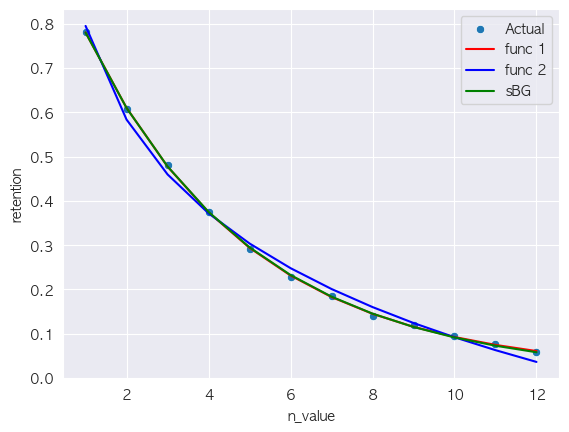

func 1 mean absolute error: 	 0.00
func 2 mean absolute error: 	 0.01
sBG mean absolute error: 	 0.00


In [791]:
# shifted beta geometric model 사용
import sbg

# 알파, 베타 적합
alpha, beta = sbg.fit(list(y))
y_pred_sbg = sbg.predicted_survival(alpha, beta, len(X))
y_pred1 = func1(X, *popt1)
y_pred2 = func2(X, *popt2)

# func 1, func 2와 비교 그래프 생성
sns.scatterplot(x=X, y=y, label='Actual')
sns.lineplot(x=X, y=y_pred1, color='r', label='func 1')
sns.lineplot(x=X, y=y_pred2, color='b', label='func 2')
sns.lineplot(x=X, y=y_pred_sbg, color='g', label='sBG')
plt.legend(loc='best')
plt.show()

# 에러 비교
print(f'func 1 mean absolute error: \t {mean_absolute_error(y, y_pred1):.2f}')
print(f'func 2 mean absolute error: \t {mean_absolute_error(y, y_pred2):.2f}')
print(f'sBG mean absolute error: \t {mean_absolute_error(y, y_pred_sbg):.2f}')

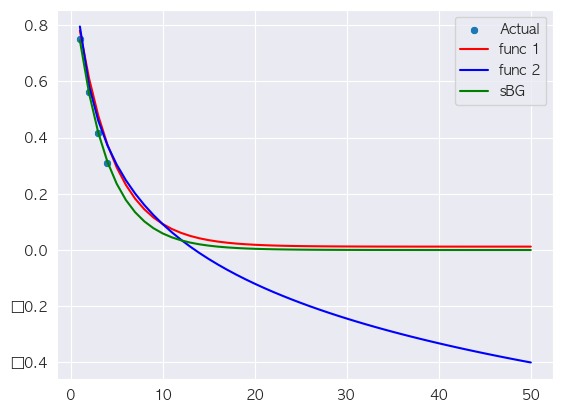

In [805]:
# M+100 예측 비교
y_pred1 = func1(np.linspace(1,50), *popt1)
y_pred2 = func2(np.linspace(1,50), *popt2)
y_pred_sbg = sbg.predicted_survival(alpha, beta, 50)

# 시각화
sns.scatterplot(x=X, y=y, label='Actual')
sns.lineplot(x=np.linspace(1,50), y=y_pred1, color='r', label='func 1')
sns.lineplot(x=np.linspace(1,50), y=y_pred2, color='b', label='func 2')
sns.lineplot(x=list(range(1, 51)), y=y_pred_sbg, color='g', label= 'sBG')
plt.legend( loc='best')
plt.show()

- 일반 함수 모델보다 예측에서 더 실제에 맞는 값이 나옴을 알 수 있음
- 따라서, sBG 모델 사용하여 E(CLV) 계산

### 4-2) 문제 제기: 코호트 반영
---

**Problem**
- CLV를 구할 때 다음과 같은 문제가 발생합니다.<br>
1. 데이터가 많은 과거의 코호트를 사용하여 예측하는 경우 예측의 정확도는 높아지지만, 최근 트렌드를 반영할 수 없습니다.
2. 데이터가 적은 최근의 코호트를 사용하여 예측하는 경우 예측의 정확도는 낮아지지만, 최근 트렌드를 반영할 수 있습니다.

**Solution**<br>
- 1개월 주기의 코호트를 나눈 후 이를 토대로 예측을 진행하고, 예측값의 평균을 사용하여 생존함수를 도출해냅니다.
- $\widehat{S(t)_n}$: n번째 코호트의 추정 생존함수
- $C$: 코호트 집합
- $\widehat{S(t)} = \frac{\sum\limits_{n=1}^\infty \widehat{S(t)_n}}{|C|}$
- $\widehat{E(CLV)} = \sum_{t=1}^\infty m \widehat{S(t)}$

**Example**

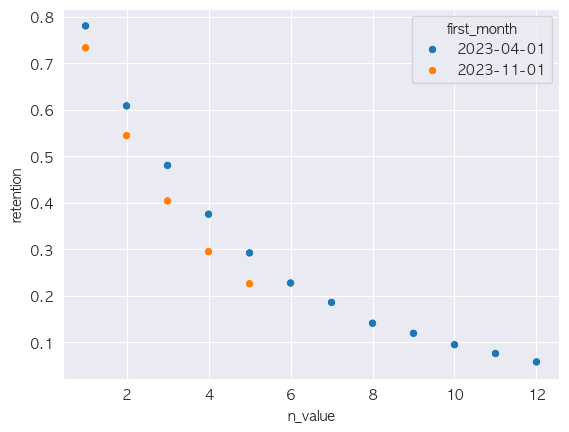

In [793]:
# 2023-4, 2023-11 코호트 사용
df_eg = df.copy()
df_eg = df_eg[(df_eg['first_month'] == '2023-04-01') | (df_eg['first_month'] == '2023-11-01')]

# 시각화
sns.scatterplot(data=df_eg, x='n_value', y='retention', hue='first_month')
plt.show()

- 2023-1 코호트: 데이터는 많지만 최근의 트렌트를 반영하지 못함
- 2024-1 코호트: 데이터는 적지만 최근의 트렌드를 반영함

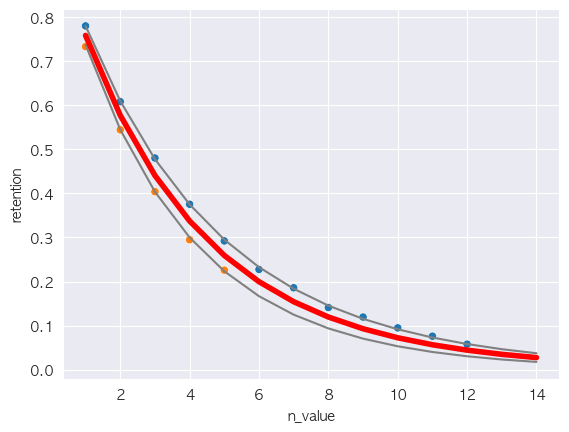

In [794]:
import pandas as pd

# 반복 작업에 사용할 코호트 리스트
first_month_li = list(df_eg['first_month'].unique())

# 결과 저장할 데이터 프레임
df_pred_eg = pd.DataFrame()

# 코호트별로 반복 작업
for first_month in first_month_li:
    y = df_eg[df_eg['first_month'] == first_month]['retention'].values              # 예측에 사용될 값
    X = df_eg[df_eg['first_month'] == first_month]['n_value'].values                # t
        
    alpha, beta = sbg.fit(y)                                                        # alpha, beta 적합
    
    s_t = sbg.predicted_survival(alpha, beta, 200)                                  # t=200까지 적합
            
    pred = pd.DataFrame({'t': list(range(1,201)),                                   # 데이터 프레임으로 생성(편리한 시각화를 위해)
                         'S(t)': sbg.predicted_survival(alpha, beta, 200)})
                                    
    pred['first_month'] = first_month                                               # 데이터프레임에 코호트 표기
        
    df_pred_eg = pd.concat([df_pred_eg, pred])                                      # 반복되어 나온 결과를 병합

# 예측값의 평균을 저장하기 위한 데이터프레임
df_mean_eg = df_pred_eg.copy()                                                      

# 평균 계산
df_mean_eg = df_mean_eg.filter(['t','S(t)']).groupby(['t'], as_index=False).mean()  

# 시각화
sns.scatterplot(data=df_eg, x='n_value', y='retention', hue='first_month')
sns.lineplot(data=df_pred_eg[df_pred_eg['t'] <= 14], x='t', y='S(t)', hue='first_month', palette=['grey'])
sns.lineplot(data=df_mean_eg[df_mean_eg['t'] <= 14], x='t', y='S(t)', color='red', linewidth=4)
plt.legend().remove()
plt.show()

- 각 코호트의 예측값의 평균을 추정 생존 함수로 사용한다.

**ETC**<br>
- 코호트의 평균을 토대로 예측하지 않고 코호트별 생존 추정 함수값을 사용하는 이유

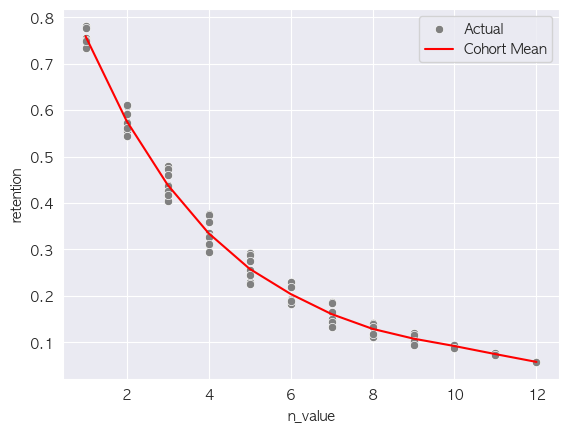

In [795]:
# 각 코호트의 평균 계산
df_cohort_mean = df.filter(['n_value','retention']).groupby(['n_value'], as_index=False).mean()

# 시각화
sns.scatterplot(data=df, x='n_value', y='retention', color='grey', label='Actual')
sns.lineplot(data=df_cohort_mean, x='n_value', y='retention', color='red', label='Cohort Mean')
plt.legend()
plt.show()

- 코호트의 평균을 사용하면 최근의 값이 후반에 반영이 되지 않습니다. 따라서 트렌드를 반영하기 어렵습니다.

### 4-3) 분석
---

**현재 생존 그래프 확인과 생존 함수 적합**

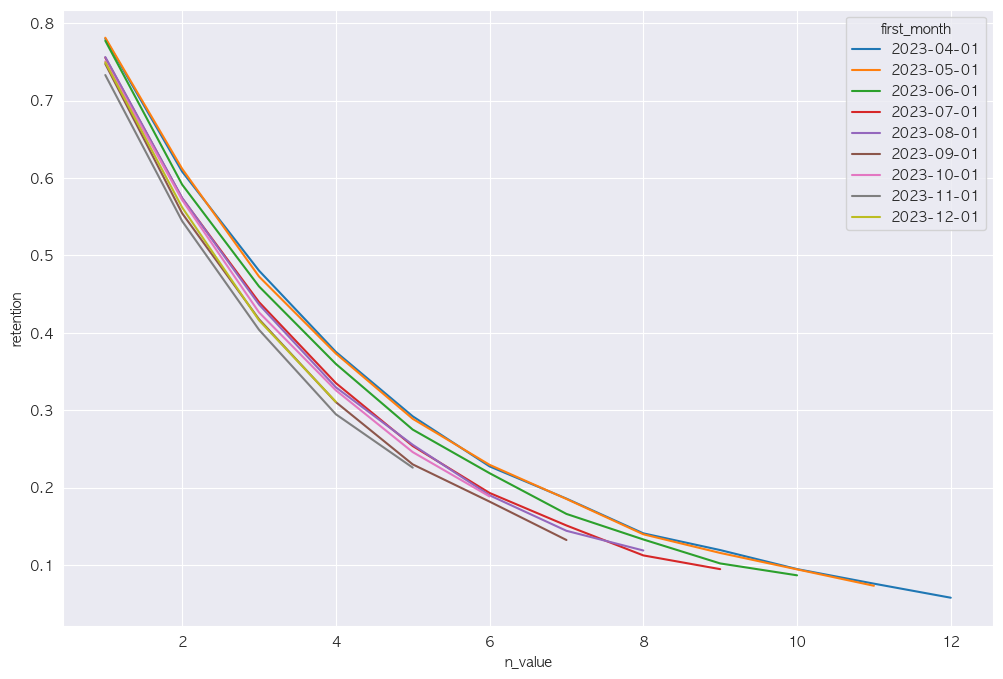

In [796]:
# 현재 생존 그래프 시각화
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='n_value', y='retention', hue='first_month')
plt.show()

**코호트별 추정 생존함수 적합**

In [797]:
# 반복 작업에 사용할 코호트 리스트
first_month_li = list(df['first_month'].unique())

# 결과 저장할 데이터 프레임
df_pred = pd.DataFrame()

print('mean absolute error')
print('========================================')

# 코호트별로 반복 작업
for first_month in first_month_li:
    y = df[df['first_month'] == first_month]['retention'].values                    # 예측에 사용될 값
    X = df[df['first_month'] == first_month]['n_value'].values                      # t
        
    alpha, beta = sbg.fit(y)                                                        # alpha, beta 적합
    
    s_t = sbg.predicted_survival(alpha, beta, 200)                                  # t=200까지 적합
            
    pred = pd.DataFrame({'t': list(range(1,201)),                                   # 데이터 프레임으로 생성(편리한 시각화를 위해)
                         'S(t)': sbg.predicted_survival(alpha, beta, 200)})
                                    
    pred['first_month'] = first_month                                               # 데이터프레임에 코호트 표기
        
    df_pred = pd.concat([df_pred, pred])                                            # 반복되어 나온 결과를 병합
    
    # 정확도 계산
    from sklearn.metrics import mean_absolute_error
    
    y_pred = sbg.predicted_survival(alpha, beta, len(X))
    
    error = mean_absolute_error(y, y_pred) * 100
    print(f'{first_month}', 'cohort error:     \t\t' ,f'{error:.2f}%')

mean absolute error
2023-04-01 cohort error:     		 0.25%
2023-05-01 cohort error:     		 0.27%
2023-06-01 cohort error:     		 0.32%
2023-07-01 cohort error:     		 0.26%
2023-08-01 cohort error:     		 0.24%
2023-09-01 cohort error:     		 0.26%
2023-10-01 cohort error:     		 0.17%
2023-11-01 cohort error:     		 0.25%
2023-12-01 cohort error:     		 0.31%


**코호트별 추정 생존 함수 확인**

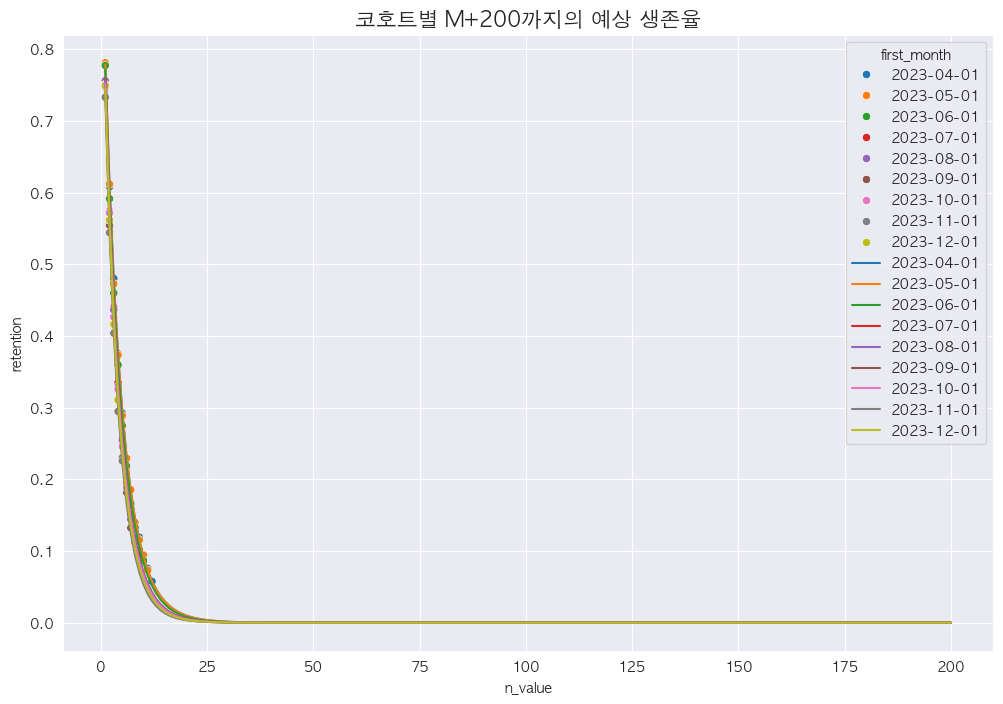

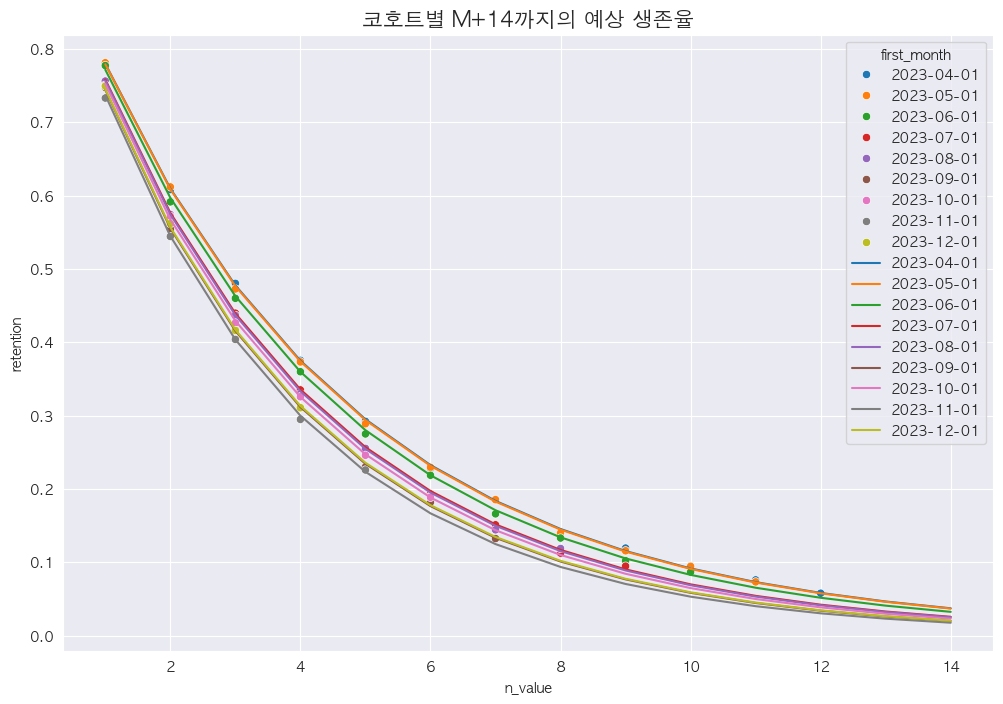

In [798]:
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df, x='n_value', y='retention', hue='first_month')
sns.lineplot(data=df_pred, x='t', y='S(t)', hue='first_month')
plt.title('코호트별 M+200까지의 예상 생존율', fontsize=15)
plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(data=df[df['n_value'] <= 14], x='n_value', y='retention', hue='first_month')
sns.lineplot(data=df_pred[df_pred['t'] <= 14], x='t', y='S(t)', hue='first_month')
plt.title('코호트별 M+14까지의 예상 생존율', fontsize=15)
plt.show()

**평균 추정 생존 함수 도출**

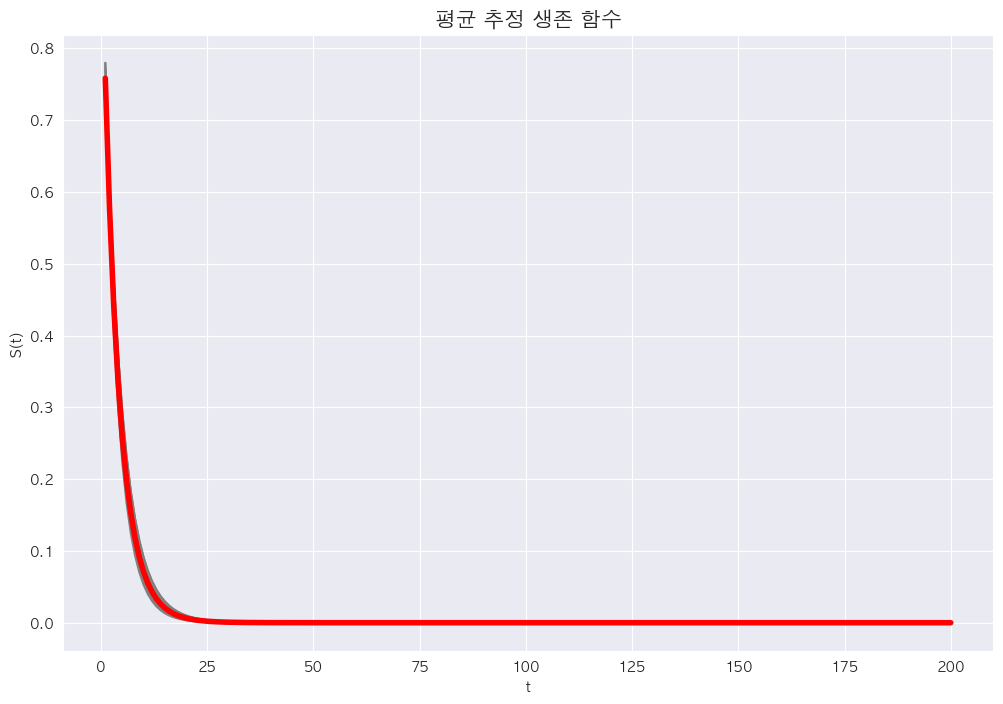

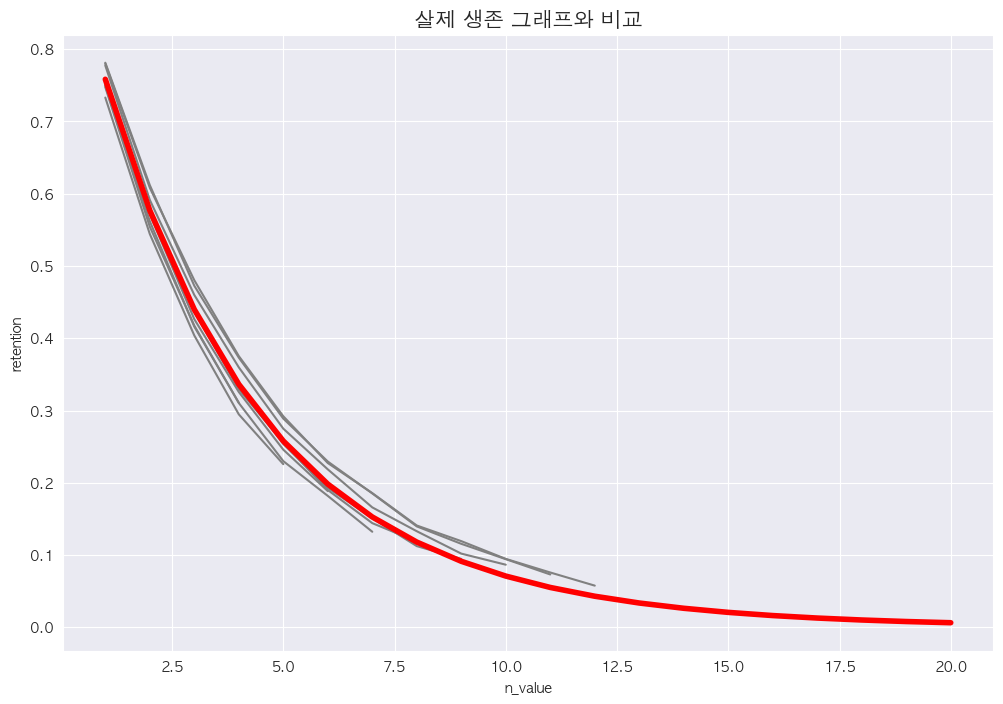

In [799]:
df_mean = df_pred.copy()

# 평균 계산
df_mean = df_mean.filter(['t','S(t)']).groupby(['t'], as_index=False).mean()

# 시각화
plt.figure(figsize=(12,8))
sns.lineplot(data=df_pred, x='t', y='S(t)', hue='first_month', palette=['grey'])
sns.lineplot(data=df_mean, x='t', y='S(t)', color='red', linewidth=4)
plt.title('평균 추정 생존 함수', fontsize=15)
plt.legend().remove()
plt.show()

plt.figure(figsize=(12,8))
sns.lineplot(data=df[df['n_value'] <= 14], x='n_value', y='retention', hue='first_month' , palette=['grey'])
sns.lineplot(data=df_mean[df_mean['t'] <= 20], x='t', y='S(t)', color='red', linewidth=4)
plt.title('살제 생존 그래프와 비교', fontsize=15)
plt.legend().remove()
plt.show()

**추정 리텐션 (r(t))**

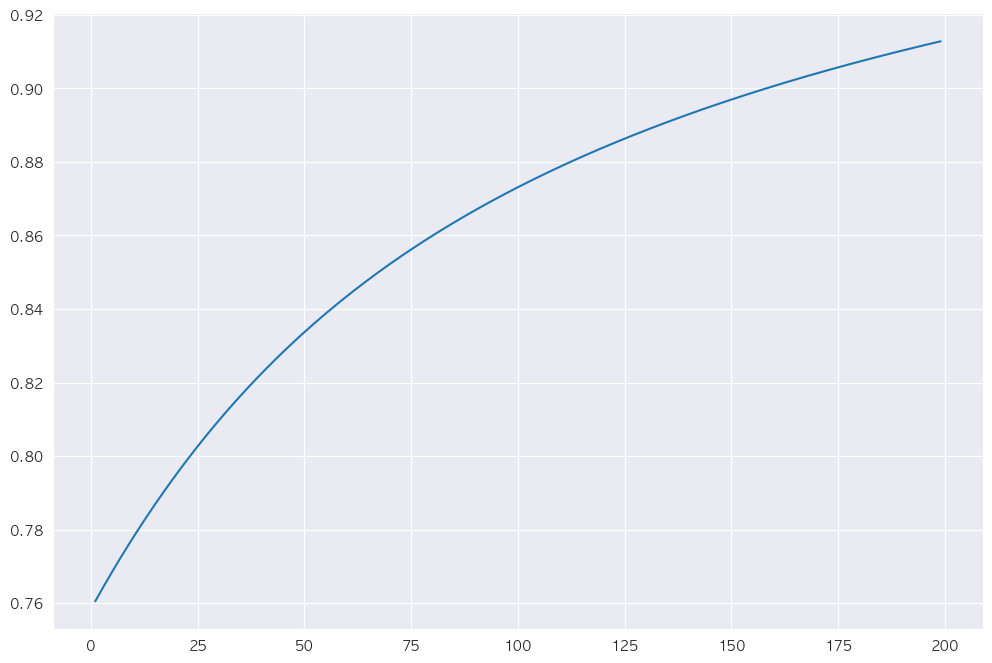

In [800]:
#리텐션 계산
s_t = list(df_mean['S(t)'])
r_t = []

for i in range(len(df_mean)):
    if i == 0:
       r_i = 1                      # r(0)은 없음
    else:
        r_i = s_t[i] / s_t[i-1]     # r(t) = S(t) / S(t-1)
        
    r_t.append(r_i)

plt.figure(figsize=(12,8))
sns.lineplot(x=list(range(1,200)), y=r_t[1:])   # r(0) 빼고 시각화

plt.show()

## 5. 결과
---

In [801]:
avg_rev = 490 * (1 / 4) + 990 * (3 / 4)
avg_sub = 1.3
exp_mon = df_mean['S(t)'].sum() + 1
e_clv = exp_mon * avg_rev * avg_sub

print(f'인당 평균 수수료(가정): \t\t{avg_rev:.0f}')
print(f'인당 평균 구독 개수(가정): \t\t{avg_sub}')
print(f'expected lifetime: \t\t{exp_mon:.2f} month')
print(f'E(CLV): \t\t\t{e_clv:.2f}')

인당 평균 수수료(가정): 		865
인당 평균 구독 개수(가정): 		1.3
expected lifetime: 		4.26 month
E(CLV): 			4789.06


- 누적 유저 가치

In [802]:
df_mean['expected_value'] = df_mean['S(t)'] * avg_rev
df_mean['cumulative_value'] = df_mean['expected_value'].cumsum()
df_mean

,t,S(t),expected_value,cumulative_value
0,1,7.584318e-01,6.560435e+02,656.043503
1,2,5.768117e-01,4.989422e+02,1154.985657
2,3,4.398774e-01,3.804939e+02,1535.479593
3,4,3.363478e-01,2.909408e+02,1826.420433
4,5,2.578605e-01,2.230493e+02,2049.469755
...,...,...,...,...
195,196,1.246953e-13,1.078614e-10,2818.893686
196,197,1.137204e-13,9.836810e-11,2818.893686
197,198,1.037429e-13,8.973757e-11,2818.893686
198,199,9.466928e-14,8.188893e-11,2818.893686


## 6. 한계점
---

본 분석은 아래와 같은 한계점이 있기 때문에 실제 사용에 유의하여야합니다. <br>
- 본 분석 결과는 유저의 평생 가치를 측정하는 것이기 때문에 변화하는 스타트업 상황에서 그대로 사용하기 어렵습니다. 따라서, CAC 회수 기간 등을 고려하여 더 짧은 기간의 기대 가치를 사용하는 것을 권장드립니다.
- 본 분석은 다양한 유저의 특성을 고려하지 않았습니다. OTT별 특성, 재구매시의 특성 등 다양한 후속 분석이 진행됨에 따라 CLV는 달라질 수 있습니다.
- 본 분석은 분석의 편리함을 위해 현실을 매우 단순화 하였습니다. 화폐 가치 하락 무시, 단순한 모델링 방법 사용 등에 따라 현실과 다른 결과가 도출될 수 있습니다.
- 본 분석은 유저를 대상으로 직접 조사한 것이 아니기 때문에 데이터 집계, 추출, 적재 과정에서 이상치가 포함되어있을 수 있습니다. 이에 따라 오류가 발생했을 가능성이 있습니다.